In [13]:
%matplotlib inline

In [14]:
import os
import pandas as pd
import numpy as np
import phoebe

from elisa import (
    settings,
    BinarySystem,
    Observer
)

from visualization import (
    params_vs_speed, 
    params_vs_precision, 
    analyze_speed, 
    analyze_precision, 
    compare_models,
    produce_params_from_row
)

import matplotlib as mpl
import matplotlib.pyplot as plt

Default binary system:

In [15]:
binary_params = {
  "system": {
    "inclination": None,
    "period": None,
    "argument_of_periastron": None,
    "gamma": 0.0,
    "eccentricity": None,
    "primary_minimum_time": 0.0,
    "phase_shift": 0.0,
    "mass_ratio": None,
    "semi_major_axis": None
  },
  "primary": {
    "surface_potential": None,
    "synchronicity": 1.0,
    "t_eff": None,
    "metallicity": 0.0
  },
  "secondary": {
    "surface_potential": None,
    "synchronicity": 1.0,
    "t_eff": None,
    "metallicity": 0.0
  }
}

Obtaining phoebe system

In [16]:
def get_binary(params, r_eq):
    b = phoebe.Bundle.default_binary()

    b.set_value("requiv@primary@component", r_eq[0])
    b.set_value("requiv@secondary@component", r_eq[1])
    b.set_value("teff@primary", params["primary"]["t_eff"] * u.K)
    b.set_value("teff@secondary", params["secondary"]["t_eff"] * u.K)
    b.set_value("abun@primary", params["primary"]["metallicity"])
    b.set_value("abun@secondary", params["secondary"]["metallicity"])
    b.set_value("syncpar@primary", params["primary"]["synchronicity"])
    b.set_value("syncpar@secondary", params['secondary']['synchronicity'])
    b.set_value("gravb_bol@primary", params['primary']['gravity_darkening'])
    b.set_value('gravb_bol@secondary', params['secondary']['gravity_darkening'])
    b.set_value('irrad_frac_refl_bol@primary', params['primary']['albedo'])
    b.set_value('irrad_frac_refl_bol@secondary', params['secondary']['albedo'])

    b.set_value('period@binary@component', params['system']['period'] * u.d)
    b.set_value("per0@binary@component", params['system']['argument_of_periastron'] * u.deg)
    b.set_value('ecc@binary@component', params['system']['eccentricity'])
    b.set_value('incl@binary@component', params['system']['inclination'] * u.deg)
    b.set_value("q@binary@component", params['system']['mass_ratio'])
    b.set_value('sma@binary@component', params['system']['semi_major_axis'] * u.solRad)

    b.set_value("irrad_method@phoebe01@phoebe@compute", "wilson")

    b.set_value('atm@primary', "ck2004")
    b.set_value('atm@secondary', "ck2004")

    b.set_value_all('ld_func_bol', value=settings.LIMB_DARKENING_LAW)
    # b.set_value_all('ld_mode_bol', value='manual')
    b.set_value_all('ld_coeffs_source_bol', value='ck2004')

    return b

Running a phoebe observations:

In [17]:
def run_observation(binary, phases, passbands):
    times = phases * binary['period@orbit'].value
    passbands = [passbands] if type(passbands) == str else passbands
    for psbnd in passbands:
        binary.add_dataset('lc', times=times, passband=PASSBAND_DICT[psbnd], dataset=psbnd)
    binary.run_compute(irrad_method='wilson')
    # binary.run_compute()
    return binary

Sampling and subsequent comparison of models between ELISa and Phoebe:

In [18]:
datafile = os.path.join(os.getcwd(), "results", "samples.csv")
df = pd.read_csv(datafile)

In [19]:
print(f"Number of samples: {df.shape[0]}")

Number of samples: 8668


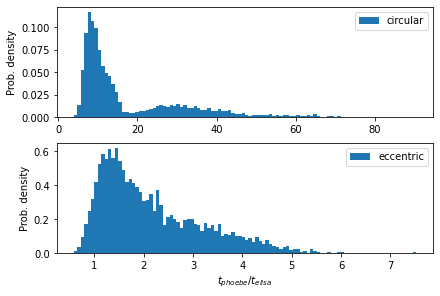

In [20]:
analyze_speed(df)

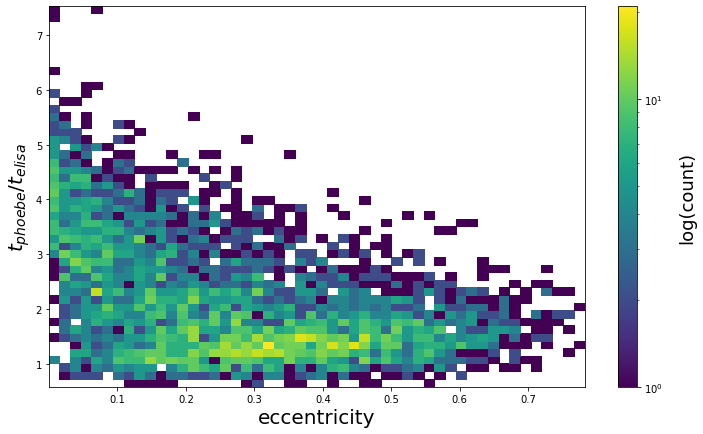

In [23]:
fig = plt.figure(figsize=(12, 7))
t_ratio = df['t_phoebe']/df['t_elisa']
eccentric = df['eccentricity'] != 0
h = plt.hist2d(df['eccentricity'][eccentric], t_ratio[eccentric], bins=50, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel('eccentricity', size=20)
plt.ylabel(r'$t_{phoebe}/t_{elisa}$', size=20)
plt.show()

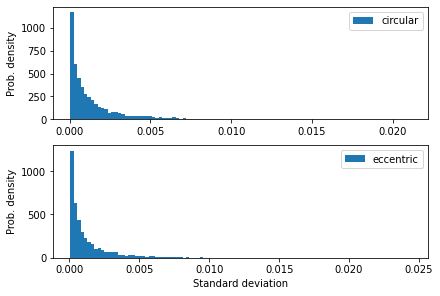

In [24]:
analyze_precision(df)

The highest discrepancy model:

2021-11-29 14:38:42,979 - 11798 - binary_system.system - INFO: initialising object BinarySystem
2021-11-29 14:38:43,026 - 11798 - binary_system.system - INFO: setting discretization factor of secondary component to 8.00 according to discretization factor of the companion.
Discretization factors: (7.0, 8.0)
Number of triangles: (1588, 1280)
Radii: 0.13 solRad, 0.03 solRad solRad
2021-11-29 14:38:45,548 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:45,602 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:45,672 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be 

2021-11-29 14:38:48,199 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:48,253 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:48,350 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:48,457 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:48,544 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K),

2021-11-29 14:38:50,931 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:50,999 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:51,057 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:51,117 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.75.
2021-11-29 14:38:51,194 - 11798 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3528K<=6600K),

100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


PHOEBE time: 20.22 s
2021-11-29 14:39:03,454 - 11798 - binary_system.system - INFO: initialising object BinarySystem
2021-11-29 14:39:03,473 - 11798 - binary_system.system - INFO: setting discretization factor of secondary component to 8.00 according to discretization factor of the companion.
2021-11-29 14:39:03,474 - 11798 - observer.observer - INFO: initialising Observer instance
2021-11-29 14:39:03,479 - 11798 - observer.observer - INFO: observation is running
2021-11-29 14:39:04,333 - 11798 - binary_system.curves.c_router - INFO: geometry of the stellar surface on one half of the apsidal line will be copied from their closest symmetrical counterparts
2021-11-29 14:39:10,409 - 11798 - observer.observer - INFO: observation finished
ELISA time: 6.96 s
Mean flux elisa: 0.9822584651609888, phoebe: 0.9875559390025895


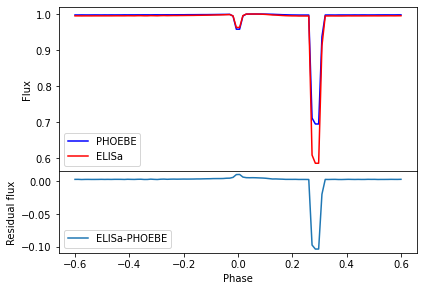

In [25]:
idd = df['max_dev'].idxmax()
compare_models(df, idd, 'TESS', n_phs=100)

In [12]:
print(df.iloc[idd])

inclination                 83.521604
period                       8.447805
argument_of_periastron      63.007532
eccentricity                 0.334619
mass_ratio                   0.145360
semi_major_axis              1.015143
p__surface_potential         4.726570
p__t_eff                  3680.327412
s__surface_potential         6.134947
s__t_eff                  8918.311640
std dev                      0.021891
max_dev                      0.098880
t_phoebe                   125.180000
t_elisa                     87.650000
N_phases                   441.000000
Name: 3101, dtype: float64


2021-11-29 14:40:03,933 - 11798 - binary_system.system - INFO: initialising object BinarySystem
2021-11-29 14:40:03,968 - 11798 - binary_system.system - INFO: setting discretization factor of secondary component to 8.00 according to discretization factor of the companion.
2021-11-29 14:40:04,108 - 11798 - observer.observer - INFO: initialising Observer instance


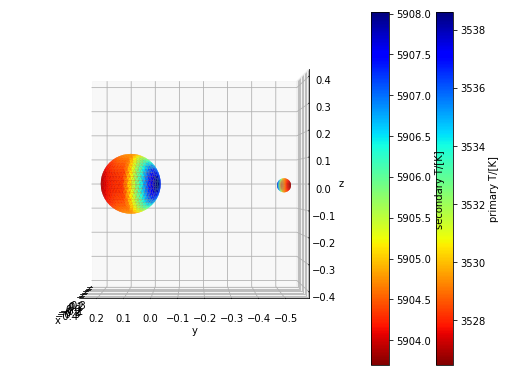

In [26]:
params = produce_params_from_row(df.iloc[idd])
system = BinarySystem.from_json(params)
system.plot.surface(phase=0.1, colormap='temperature')

The highest discrepancies correspond to models with primary t_eff below 10000 K.

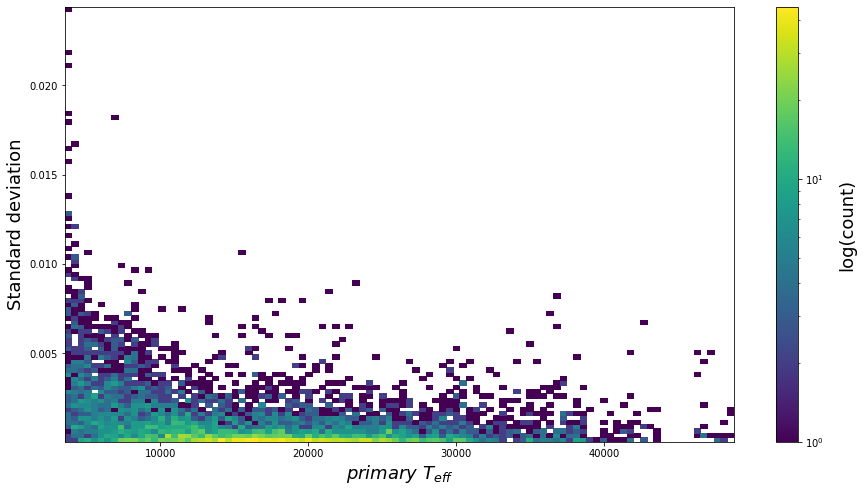

In [77]:
fig = plt.figure(figsize=(15, 8))
h = plt.hist2d(df["p__t_eff"], df["std dev"], bins=100, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel(r'$primary~T_{eff}$',size=18)
plt.ylabel('Standard deviation', size=18)
plt.show()

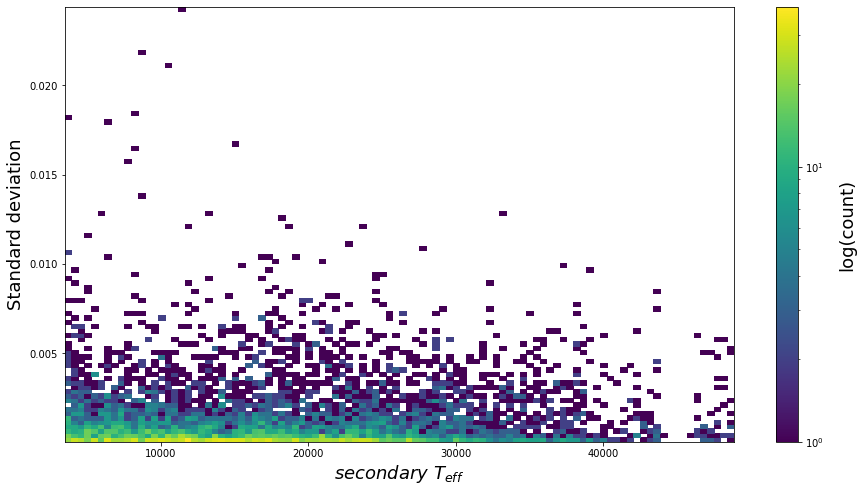

In [78]:
fig = plt.figure(figsize=(15, 8))
h = plt.hist2d(df["s__t_eff"], df["std dev"], bins=100, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel(r'$secondary~T_{eff}$',size=18)
plt.ylabel('Standard deviation', size=18)
plt.show()

Standard deviation as a function of temperature difference between the components:

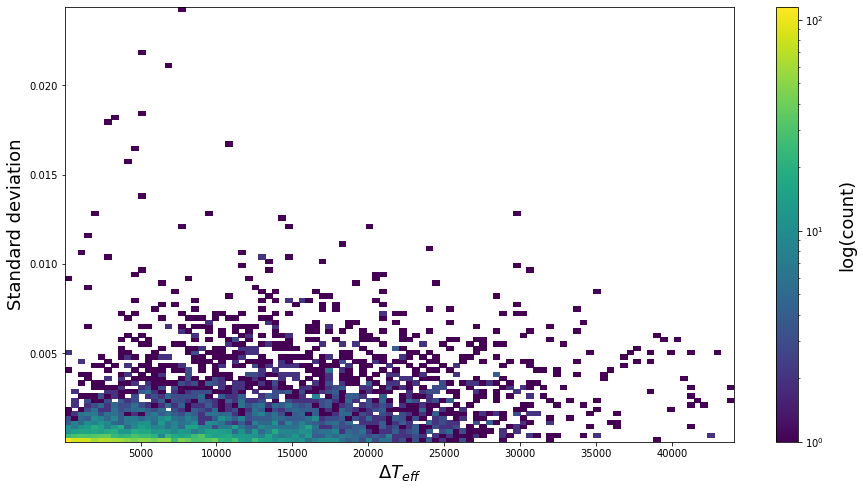

In [79]:
fig = plt.figure(figsize=(15, 8))
t_diff = np.abs((df["p__t_eff"] - df["s__t_eff"]))
h = plt.hist2d(t_diff, df["std dev"], bins=100, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel(r'$\Delta T_{eff}$',size=18)
plt.ylabel('Standard deviation', size=18)
plt.show()